<a href="https://colab.research.google.com/github/dbenet-ntu/Volcash-Project/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount gdrive before running this cell
%cd /content/drive/Othercomputers/My iMac/Desktop/leica_MF/codes

/content/drive/Othercomputers/My iMac/Desktop/leica_MF/codes


In [ ]:
!pip install mycolorpy
!pip install pca
!pip install scikit-image==0.19.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=f304f6063beadec70645fddc66514ac324f5ed819a6c28774b426f3badb8b15f
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os, random
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import lightgbm as lgb

import imagesize
import plotly.express as px

import matplotlib.image as mpimg
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from pca import pca

In [ ]:
from helper import *

In [ ]:
cwd = '/content/drive/Othercomputers/My iMac/Desktop/leica_MF'
os.chdir(cwd)
if not os.path.exists('./results'):
	os.mkdir('./results')

# mf = pd.read_csv('./results/qia2.csv', index_col = 0)
mf = pd.read_csv('/content/drive/Othercomputers/My iMac/Desktop/leica_MF/qia_final.csv', index_col = 0)
mf = mf.loc[mf.index.notna()] # to remove the embedded headers between samples
mf.index = mf.index.astype(str)
print(mf.columns)
mf.loc[:,'convexity':'value_mode'] = mf.loc[:,'convexity':'value_mode'].astype(float, errors = 'raise')

# adds relevant fields such as volcano name, magma composition, etc.
mf = add_basic_volcano_info(mf, True)

df = mf.copy() # -> to keep an unchanged copy

#df.to_csv('./dataset_process_results/df_processed2.csv')

Index(['convexity', 'rectangularity', 'elongation', 'roundness',
       'circularity_cioni', 'circularity_dellino', 'eccentricity_moments',
       'eccentricity_ellipse', 'solidity', 'aspect_rat', 'compactness',
       'circ_rect', 'comp_elon', 'circ_elon', 'rect_comp', 'contrast',
       'dissimilarity', 'homogeneity', 'energy', 'correlation', 'asm',
       'blue_mean', 'blue_std', 'blue_mode', 'blue_skew', 'green_mean',
       'green_std', 'green_mode', 'green_skew', 'red_mean', 'red_std',
       'red_mode', 'red_skew', 'hue_mean', 'hue_std', 'hue_mode',
       'saturation_mean', 'saturation_std', 'saturation_mode', 'value_mean',
       'value_std', 'value_mode'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import StandardScaler
target = 'Eruptive style'
classes2keep = ['Juvenile']

df_all, Xs, Y_num, Y_label = prepare_Xs_and_Ys(df, 'convexity', 'value_mode', target,
                                        balance_dataset = True,
                                        outlier = False,
                                        rescale_dataset = False,
                                        filter_column = 'Main type',
                                        classes2keep = classes2keep,
                                        volcano = None)

scaler = StandardScaler()
scaler.fit(Xs)
Xs = pd.DataFrame(scaler.fit_transform(Xs),columns = Xs.columns)
juvenile = Xs.copy()
juvenile['Y_label'] = Y_label.values
juvenile.to_csv('./pca/only_juveniles_target_as_eruptive_styles.csv')

/content/drive/Othercomputers/My iMac/Desktop/leica_MF/codes/helper.py:804: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.loc[:,variable_start: variable_end].iteritems():


StandardScaler()

In [ ]:
juvenile.head()

convexity  rectangularity  elongation  roundness  circularity_cioni  \
0   0.543344       -0.553964    0.052838  -0.301463           0.611162   
1   0.359781       -0.482975   -0.573999   0.616980           0.176963   
2   0.893996       -1.250777   -0.751251   0.940944           1.101671   
3   0.668386       -0.872618   -0.516797   0.519467           0.709025   
4   0.321950       -0.561057   -1.055937   1.588937           0.553460   

   circularity_dellino  eccentricity_moments  eccentricity_ellipse  solidity  \
0            -0.594713              0.441828              0.458809  0.720193   
1            -0.270919             -0.981096             -0.808463 -0.050549   
2            -0.923280             -0.965100             -1.186251  0.953351   
3            -0.663206             -0.178739             -0.098927  0.660888   
4            -0.553594             -2.209175             -2.315109  0.532315   

   aspect_rat  ...  hue_mean   hue_std  hue_mode  saturation_mean  \
0    1.264409  ... -0.274074  0.088165 -0.074174        -1.048345   
1   -0.277301  ...  0.635350 -0.962148  0.220734        -0.647098   
2    0.177393  ...  0.549032 -0.612411  0.220734        -0.989161   
3    0.020997  ...  0.715365 -0.849113  0.220734        -0.619239   
4   -0.388020  ...  0.687698 -1.040399  0.171583        -1.076731   

   saturation_std  saturation_mode  value_mean  value_std  value_mode  Y_label  
0       -0.296903        -1.173156    0.454331   0.017533    0.560022  Plinian  
1       -1.055192        -0.216285    0.813830  -1.293537    0.758078  Plinian  
2       -1.061566        -0.593234    1.094983   0.121398    1.083455  Plinian  
3       -0.977109        -0.361265    1.037783  -0.831296    1.055161  Plinian  
4       -1.397380        -0.622230    1.254272  -1.138051    1.140042  Plinian  

[5 rows x 43 columns]

Text(0.5, 1.0, 'Dendrogram')

Text(0.5, 0, 'Customers')

Text(0, 0.5, 'Euclidean distances')

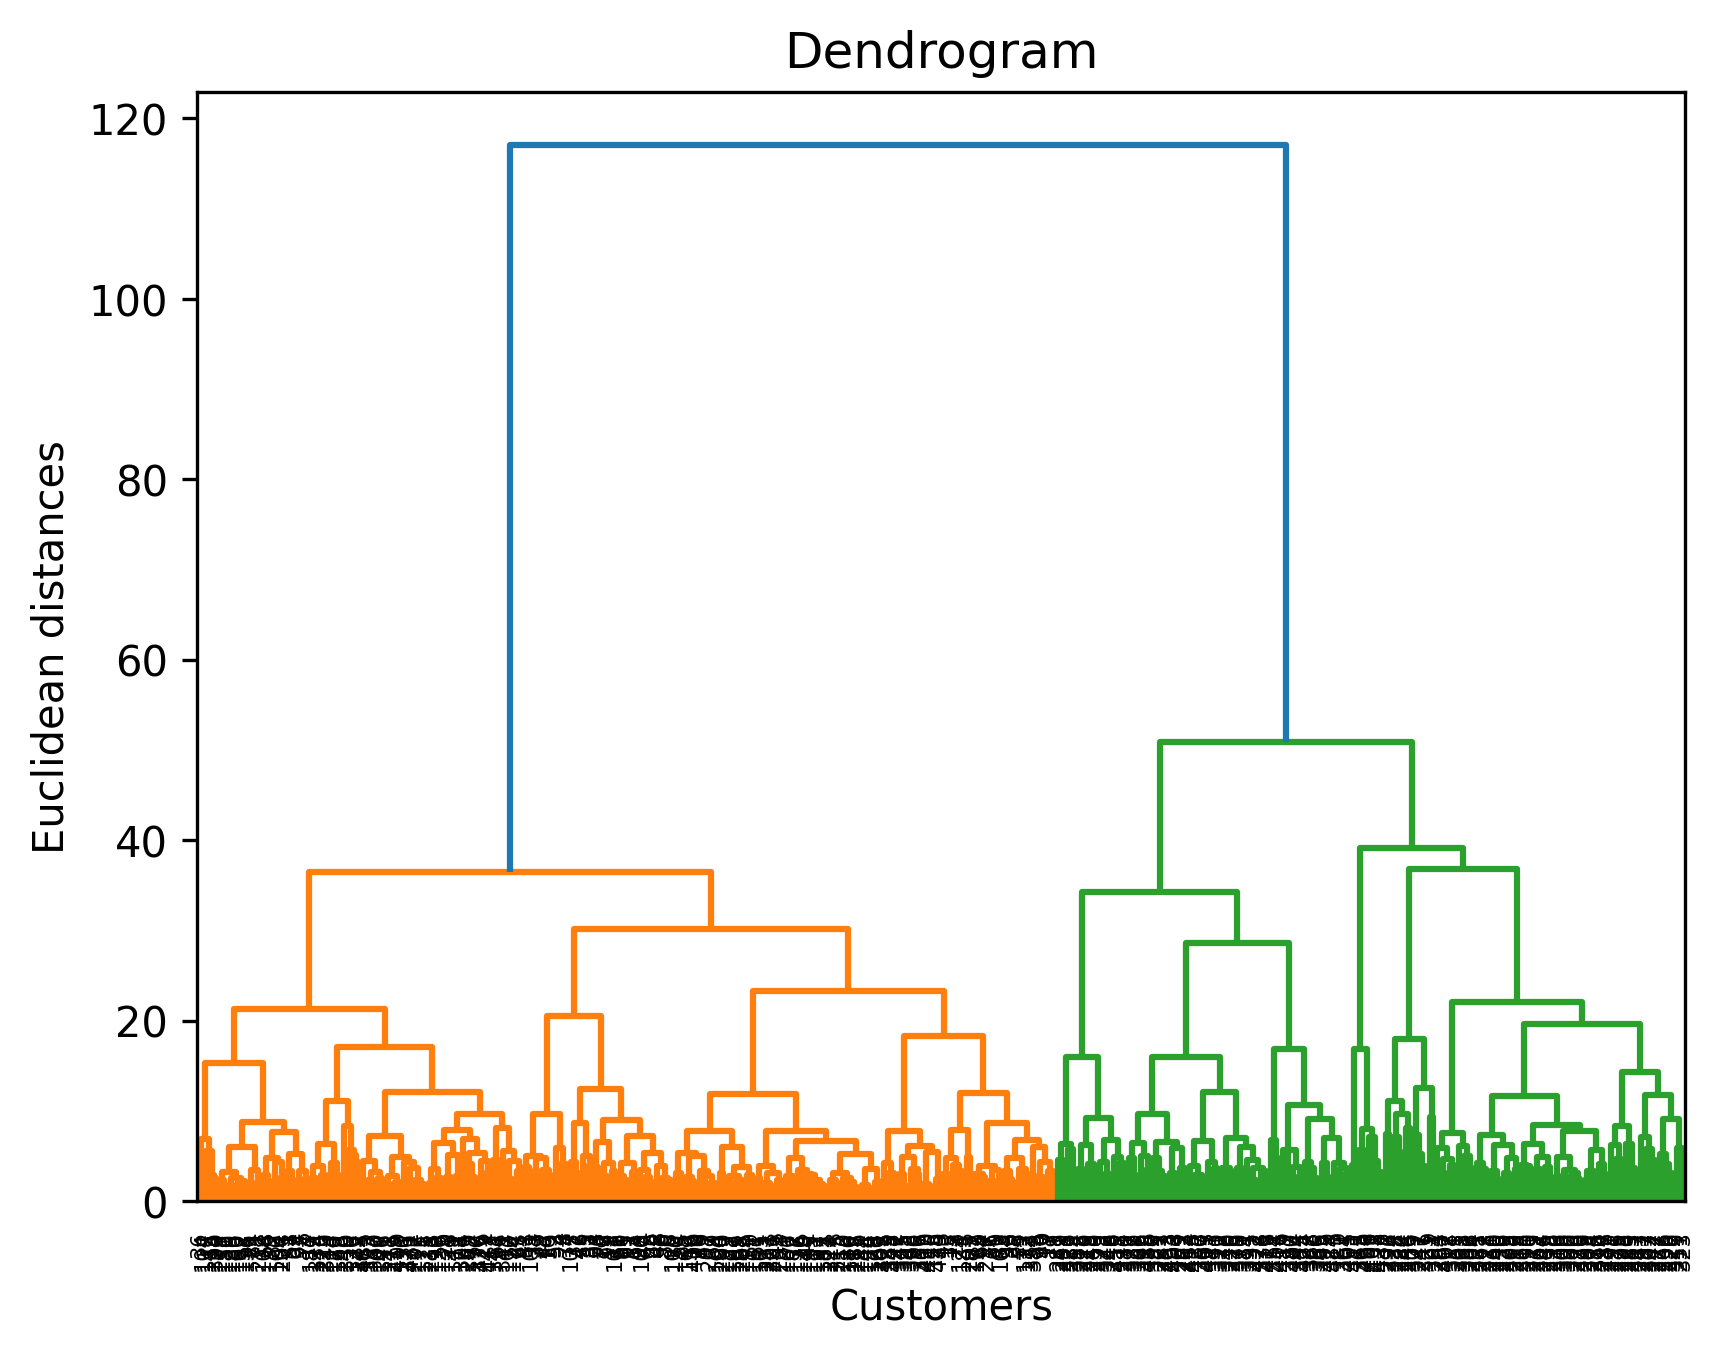

In [ ]:
import scipy.cluster.hierarchy as sch
#Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on which data we apply and engage. This is X dataset
dendrogram = sch.dendrogram(sch.linkage(juvenile.iloc[:,:-1], method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

[pca] >The PCA reduction is performed on the [42] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


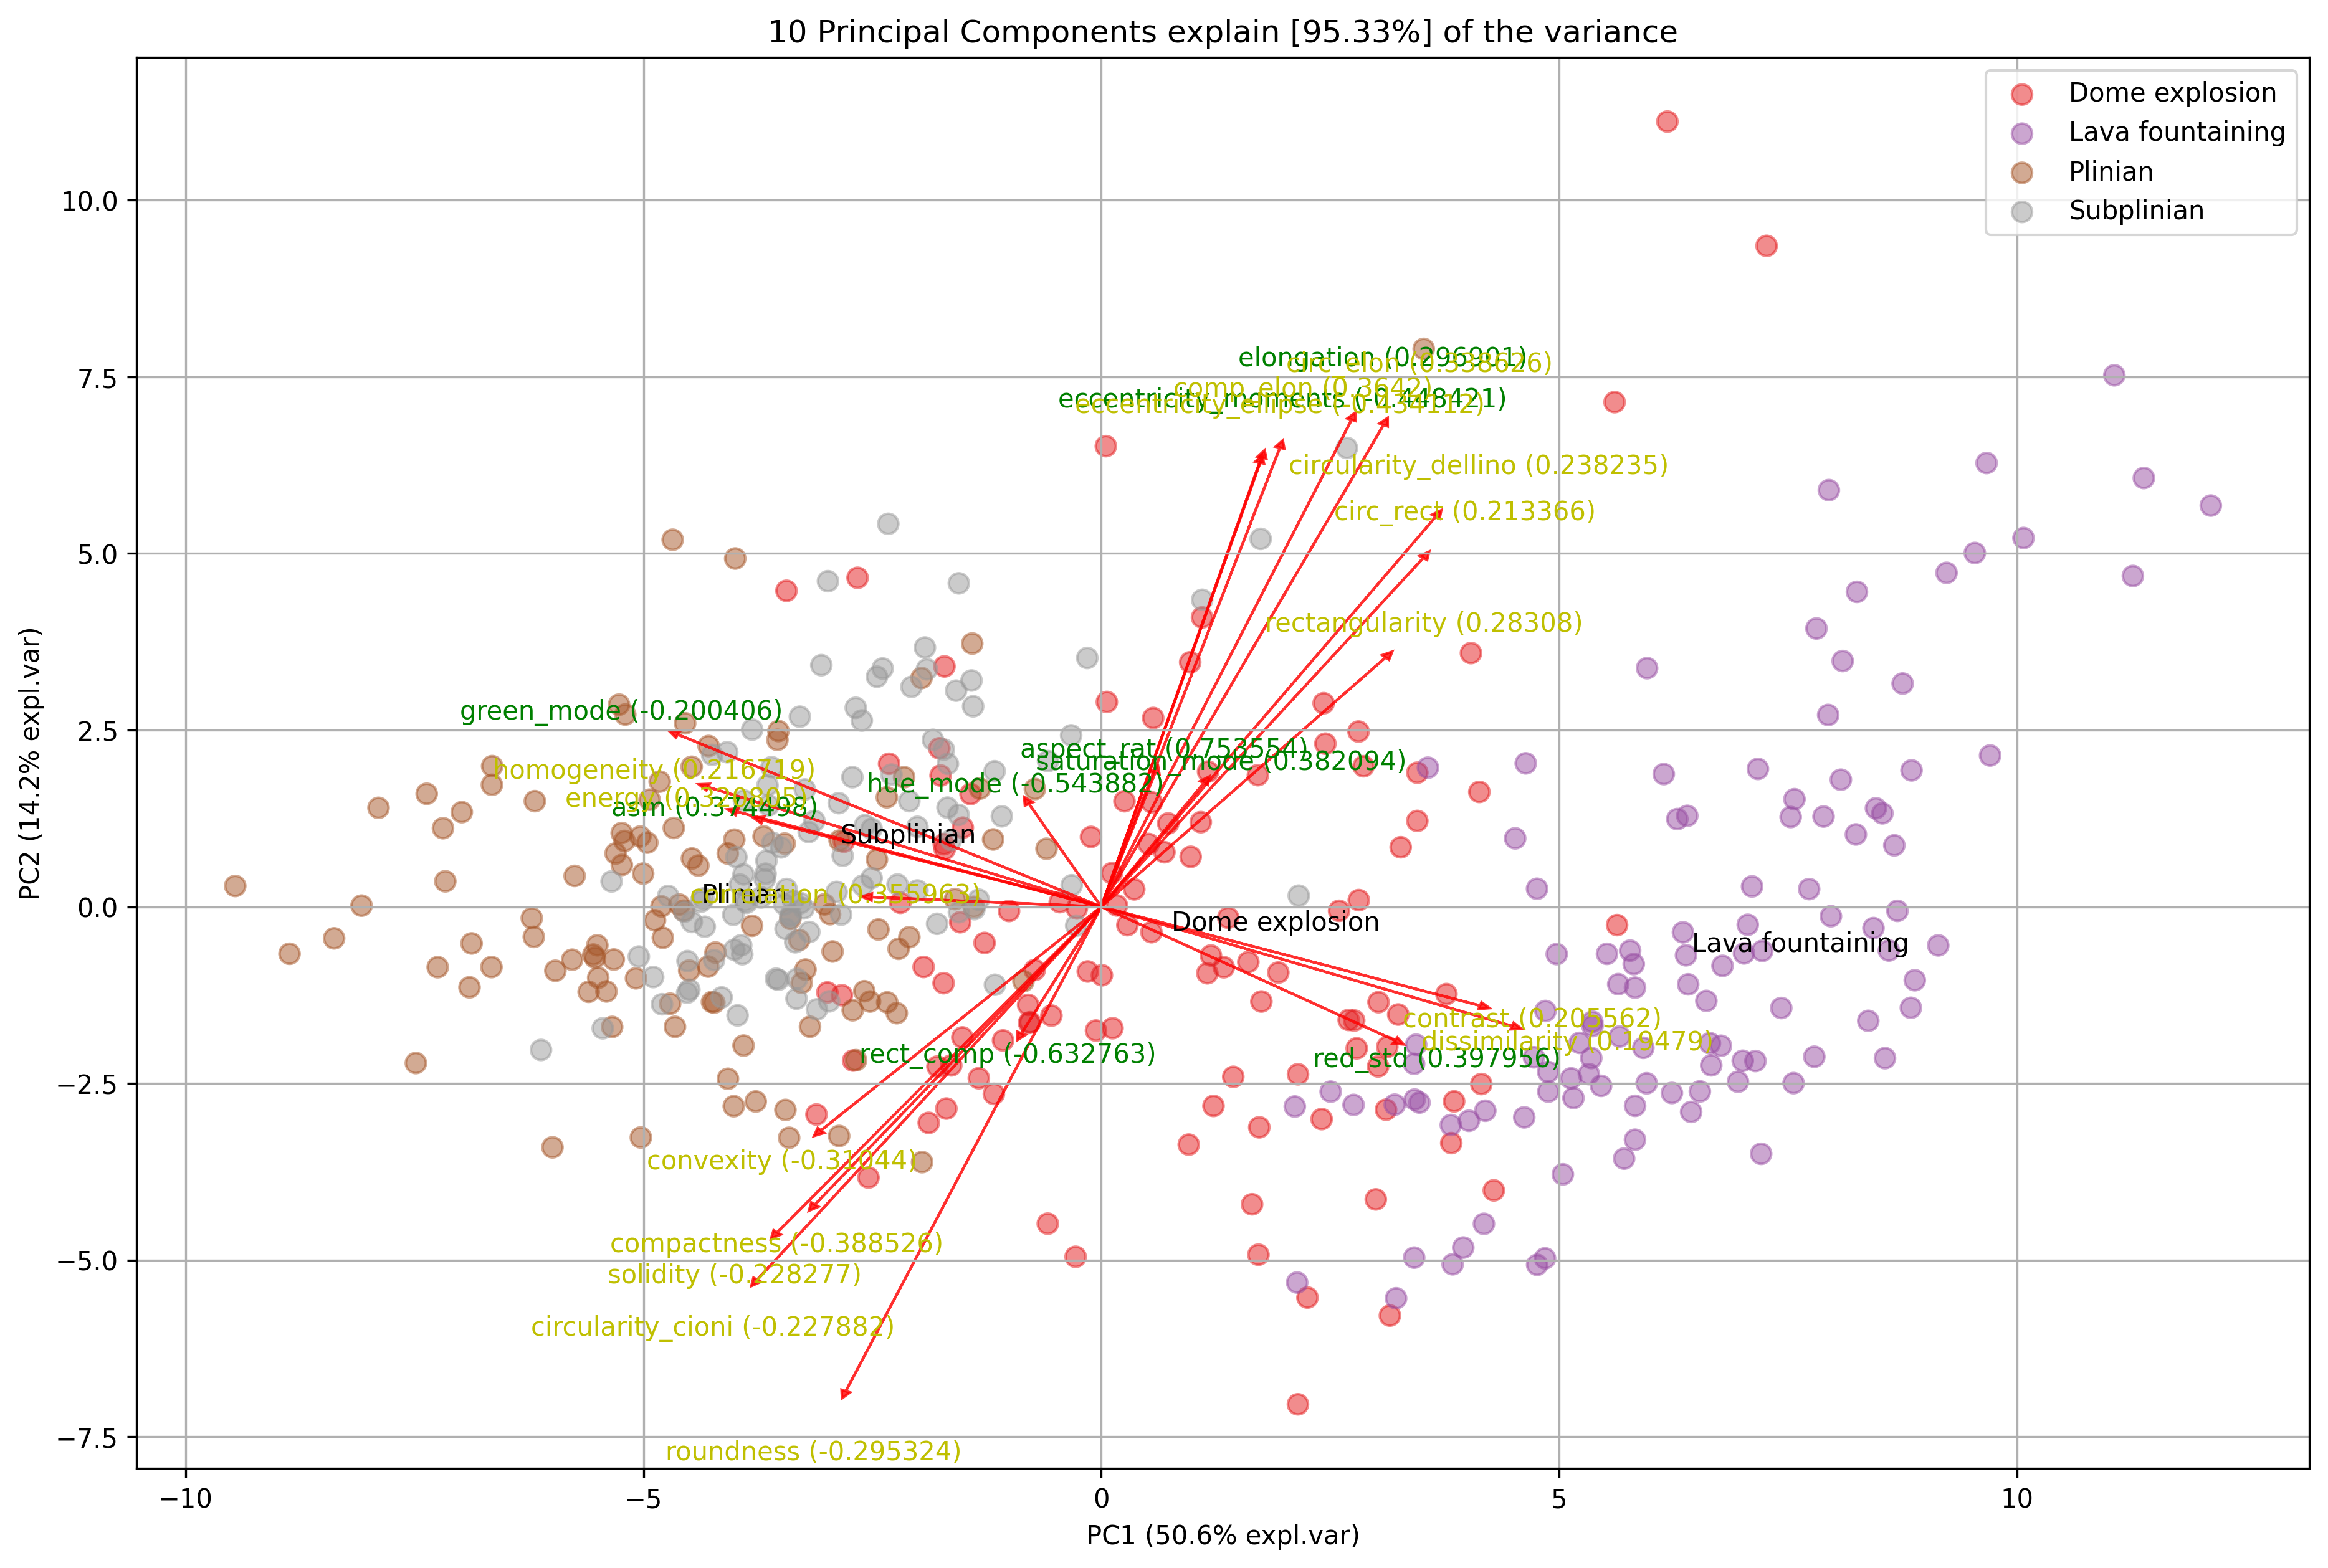

In [ ]:
# Initialize
model = pca(normalize=False, n_components=10)

# Fit transform and include the column labels and row labels
results = model.fit_transform(Xs.values, col_labels=df.loc[:,'convexity':'value_mode'].columns, row_labels=Y_label.values)

# Scatter plot with loadings
fig, ax = model.biplot(alpha_transparency=0.5)
fig.savefig('./pca/biplot.svg')

In [ ]:
# This is to save the data in csv files, but only pd.dfs!
l = ['loadings', 'PC', 'explained_var', 'variance_ratio', 'model', 'scaler', 'pcp', 'topfeat', 'outliers', 'outliers_params']
for i in l:
  x = model.results.get(i)
  if isinstance(x, pd.DataFrame):
    x.to_csv(f'./pca/{i}.csv')
  else:print(x)

dict_keys(['loadings', 'PC', 'explained_var', 'variance_ratio', 'model', 'scaler', 'pcp', 'topfeat', 'outliers', 'outliers_params'])
[0.50601621 0.64819536 0.72185309 0.78225719 0.83037772 0.86588472
 0.89737723 0.92219153 0.94180673 0.95334402]
[0.50601621 0.14217915 0.07365773 0.0604041  0.04812053 0.035507
 0.0314925  0.02481431 0.0196152  0.01153728]
PCA(n_components=10)
None
0.9533440151794426
{'paramT2': (2.5837917664003643e-17, 4.004044863753661), 'paramSPE': (array([2.82602224e-17, 1.19096652e-16]), array([[ 2.13010923e+01, -1.75353531e-13],
       [-1.75353531e-13,  5.98512695e+00]]))}


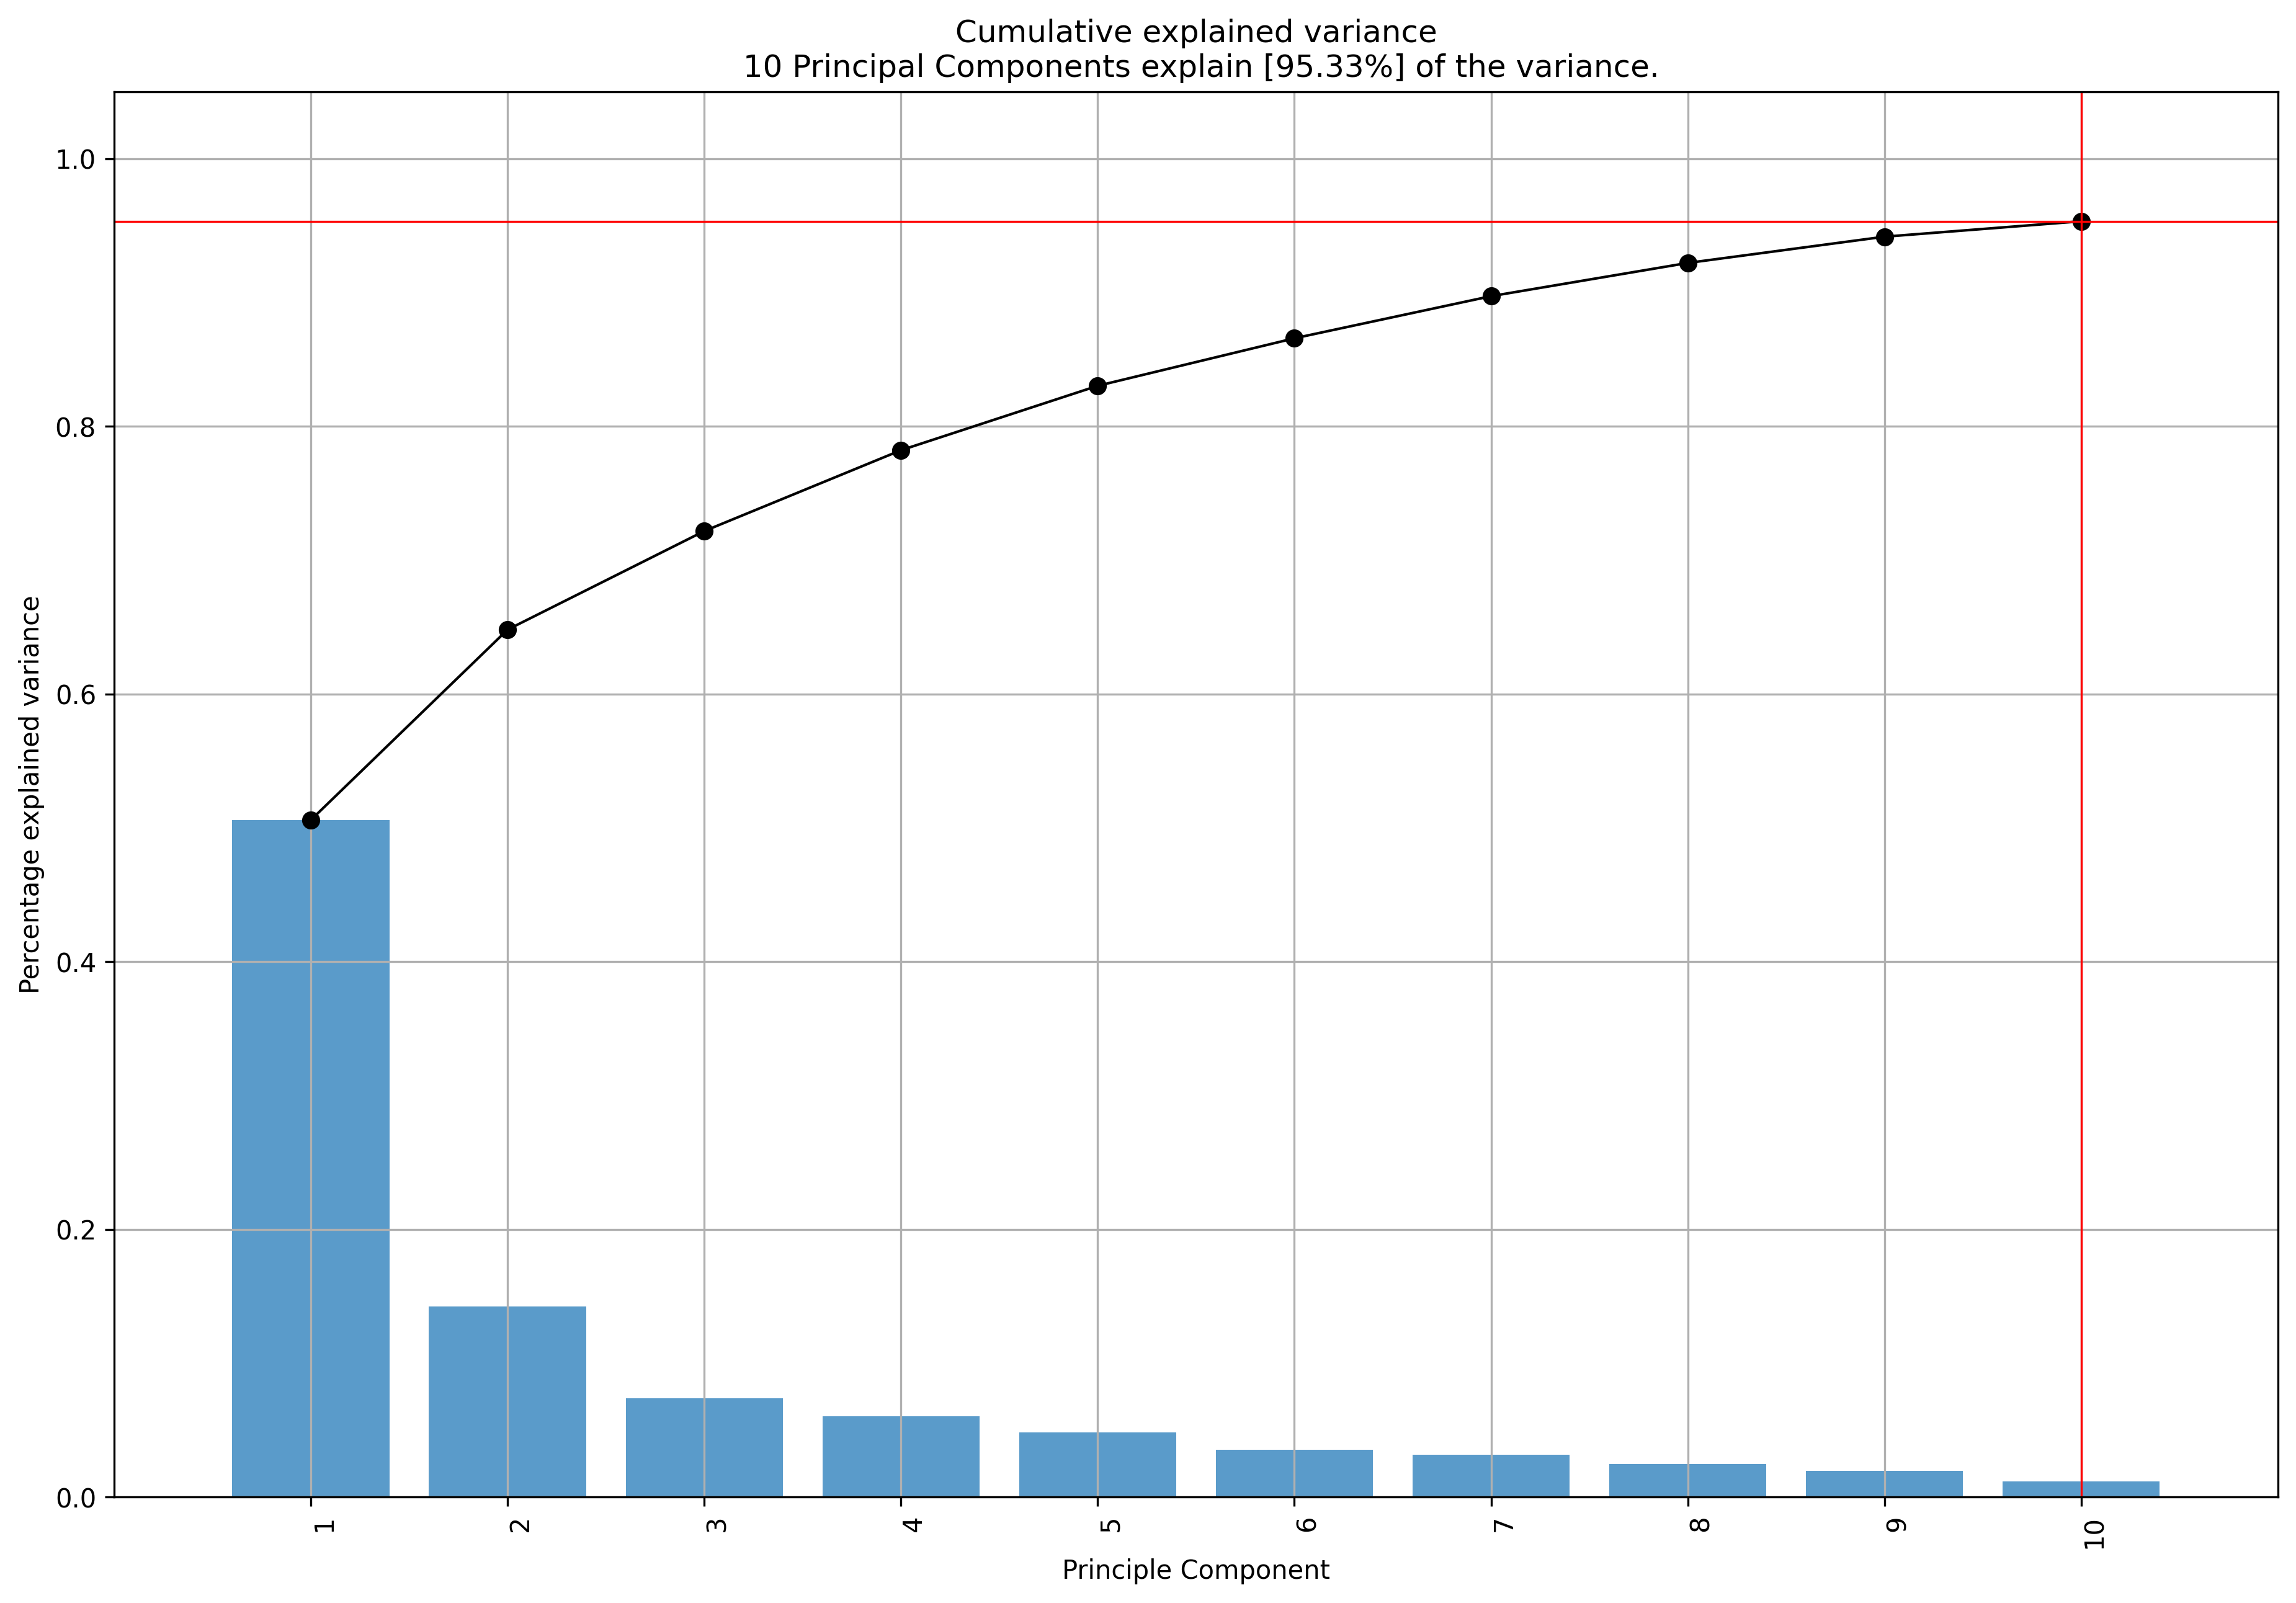

<Figure size 1800x1200 with 0 Axes>

In [ ]:
# Plot the explained variance
fig, ax = model.plot()
fig.savefig('./pca/explained_variance.svg')

In [ ]:
# importing the modules
from IPython.display import display
df2 = model.results['topfeat']
df2.to_csv('./pca/loading.csv')

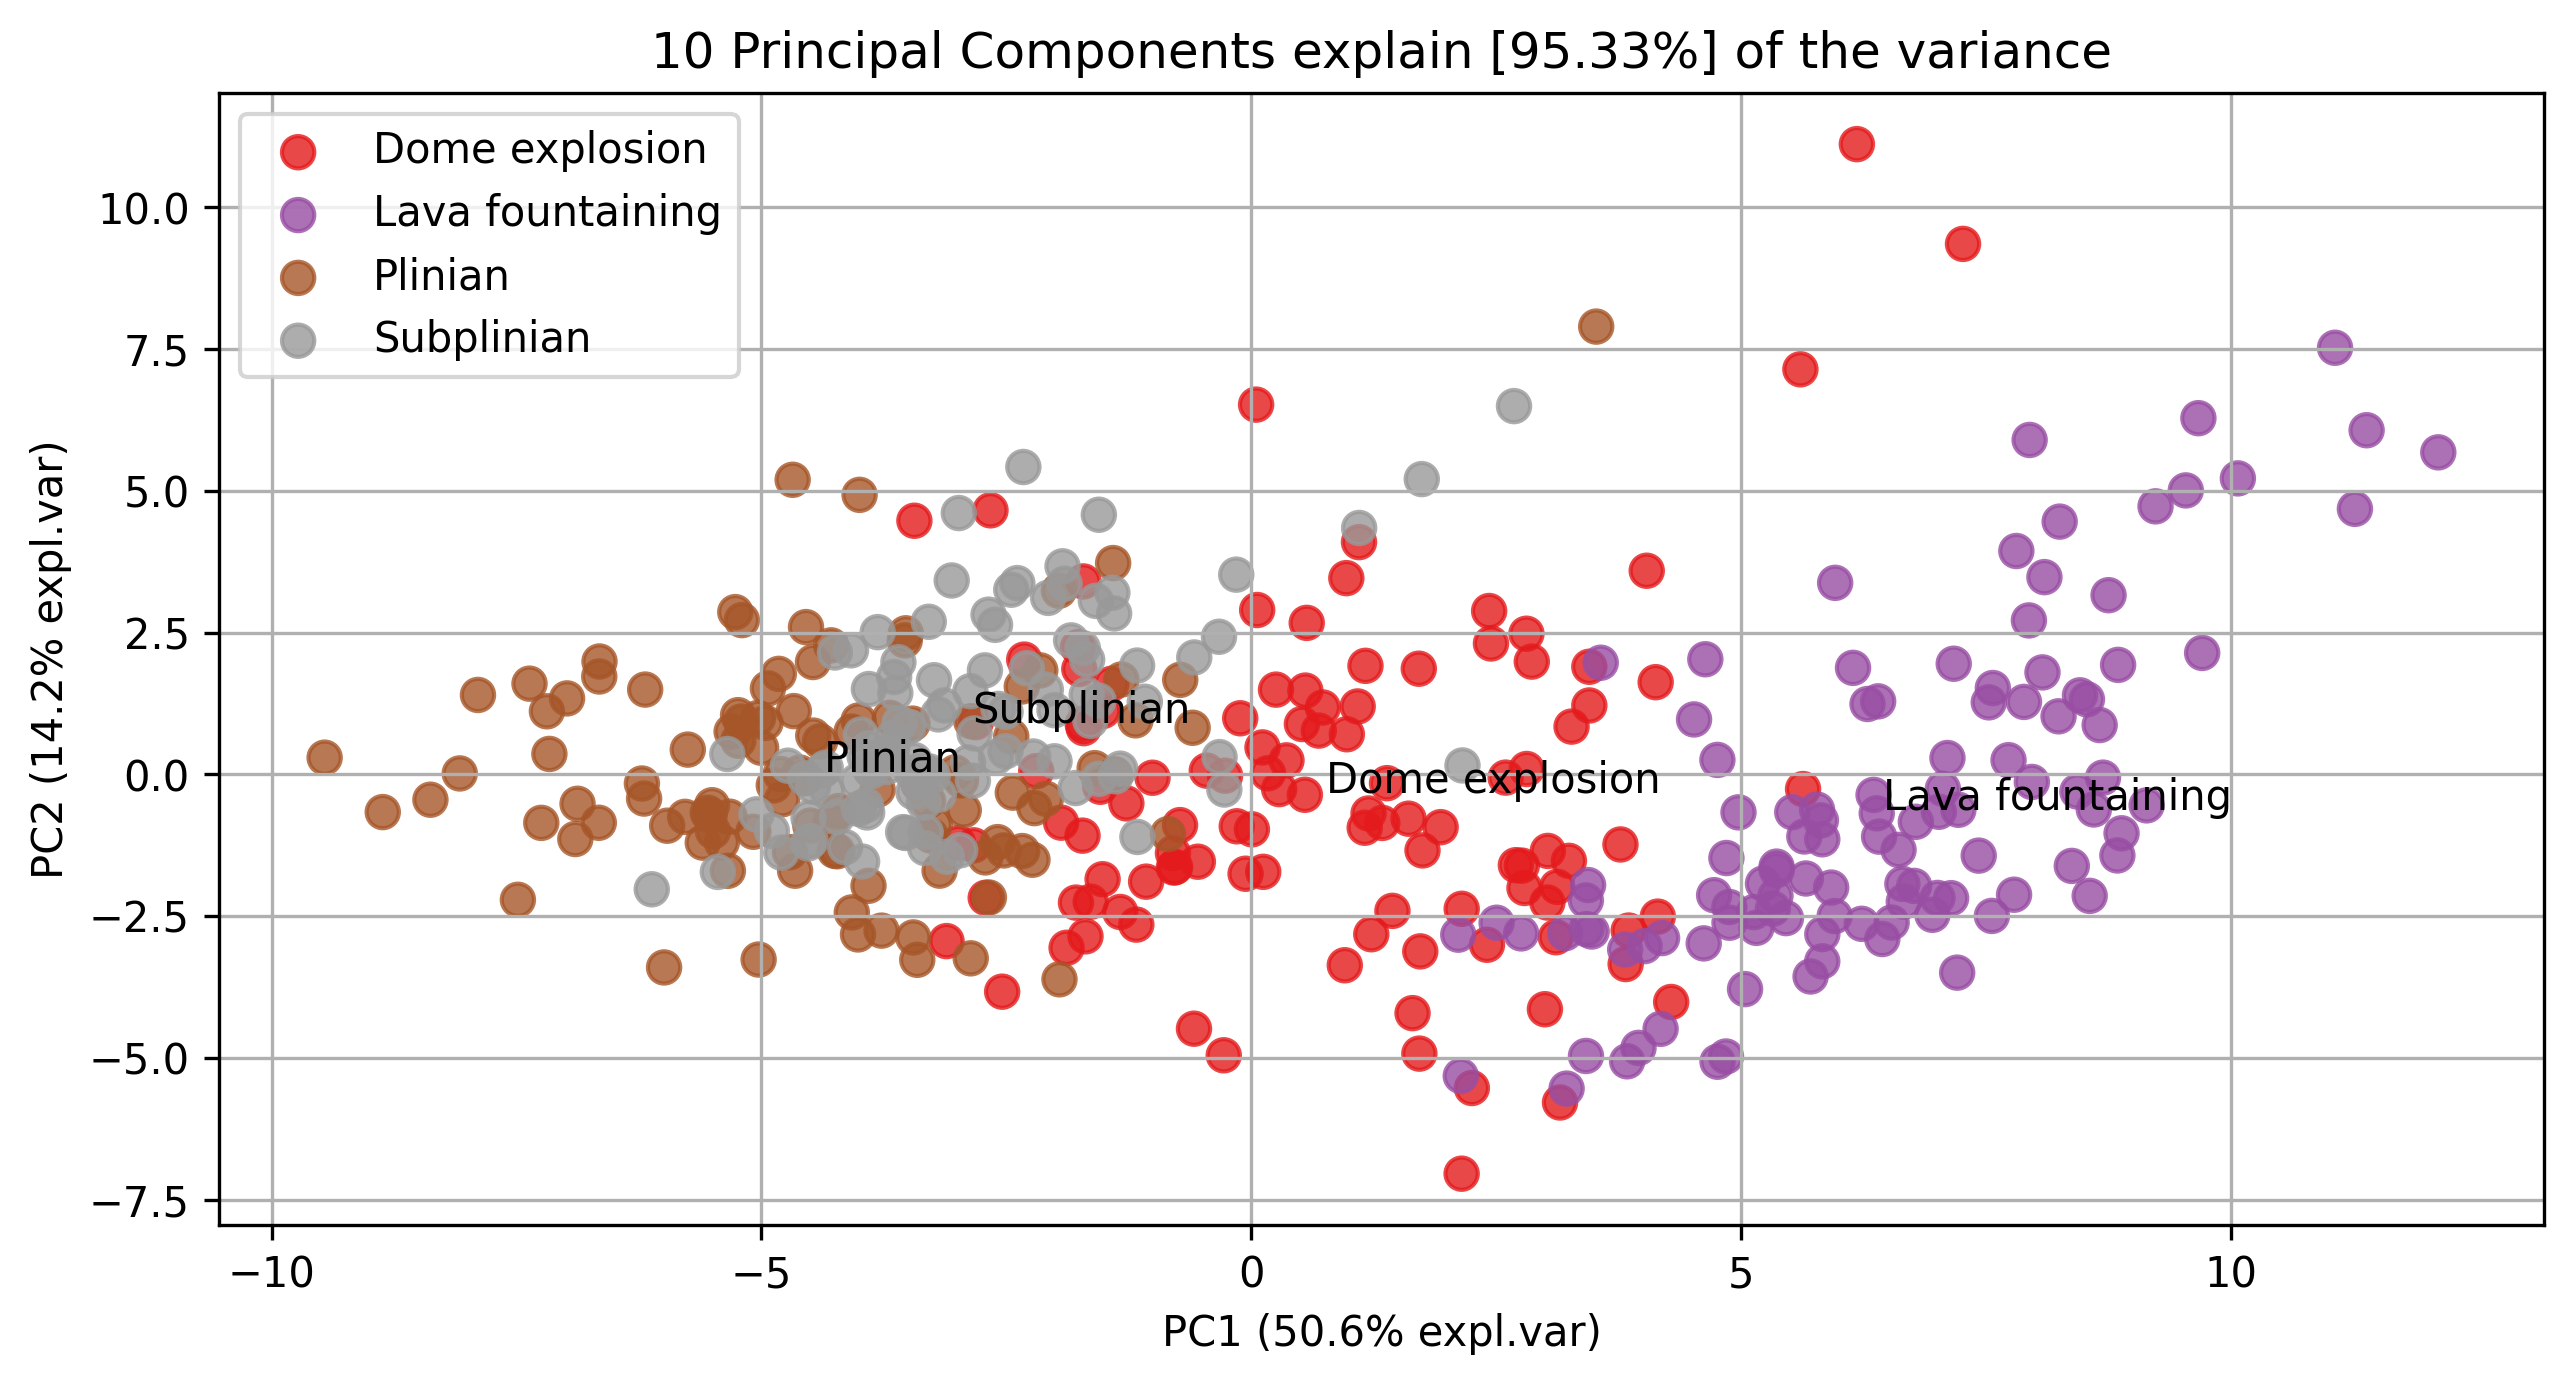

In [ ]:
fig, ax = model.scatter(PC = [0,1], alpha_transparency=0.8)
fig.set_size_inches(10, 5)
fig.savefig('./pca/scatter_pc0_pc1.svg')

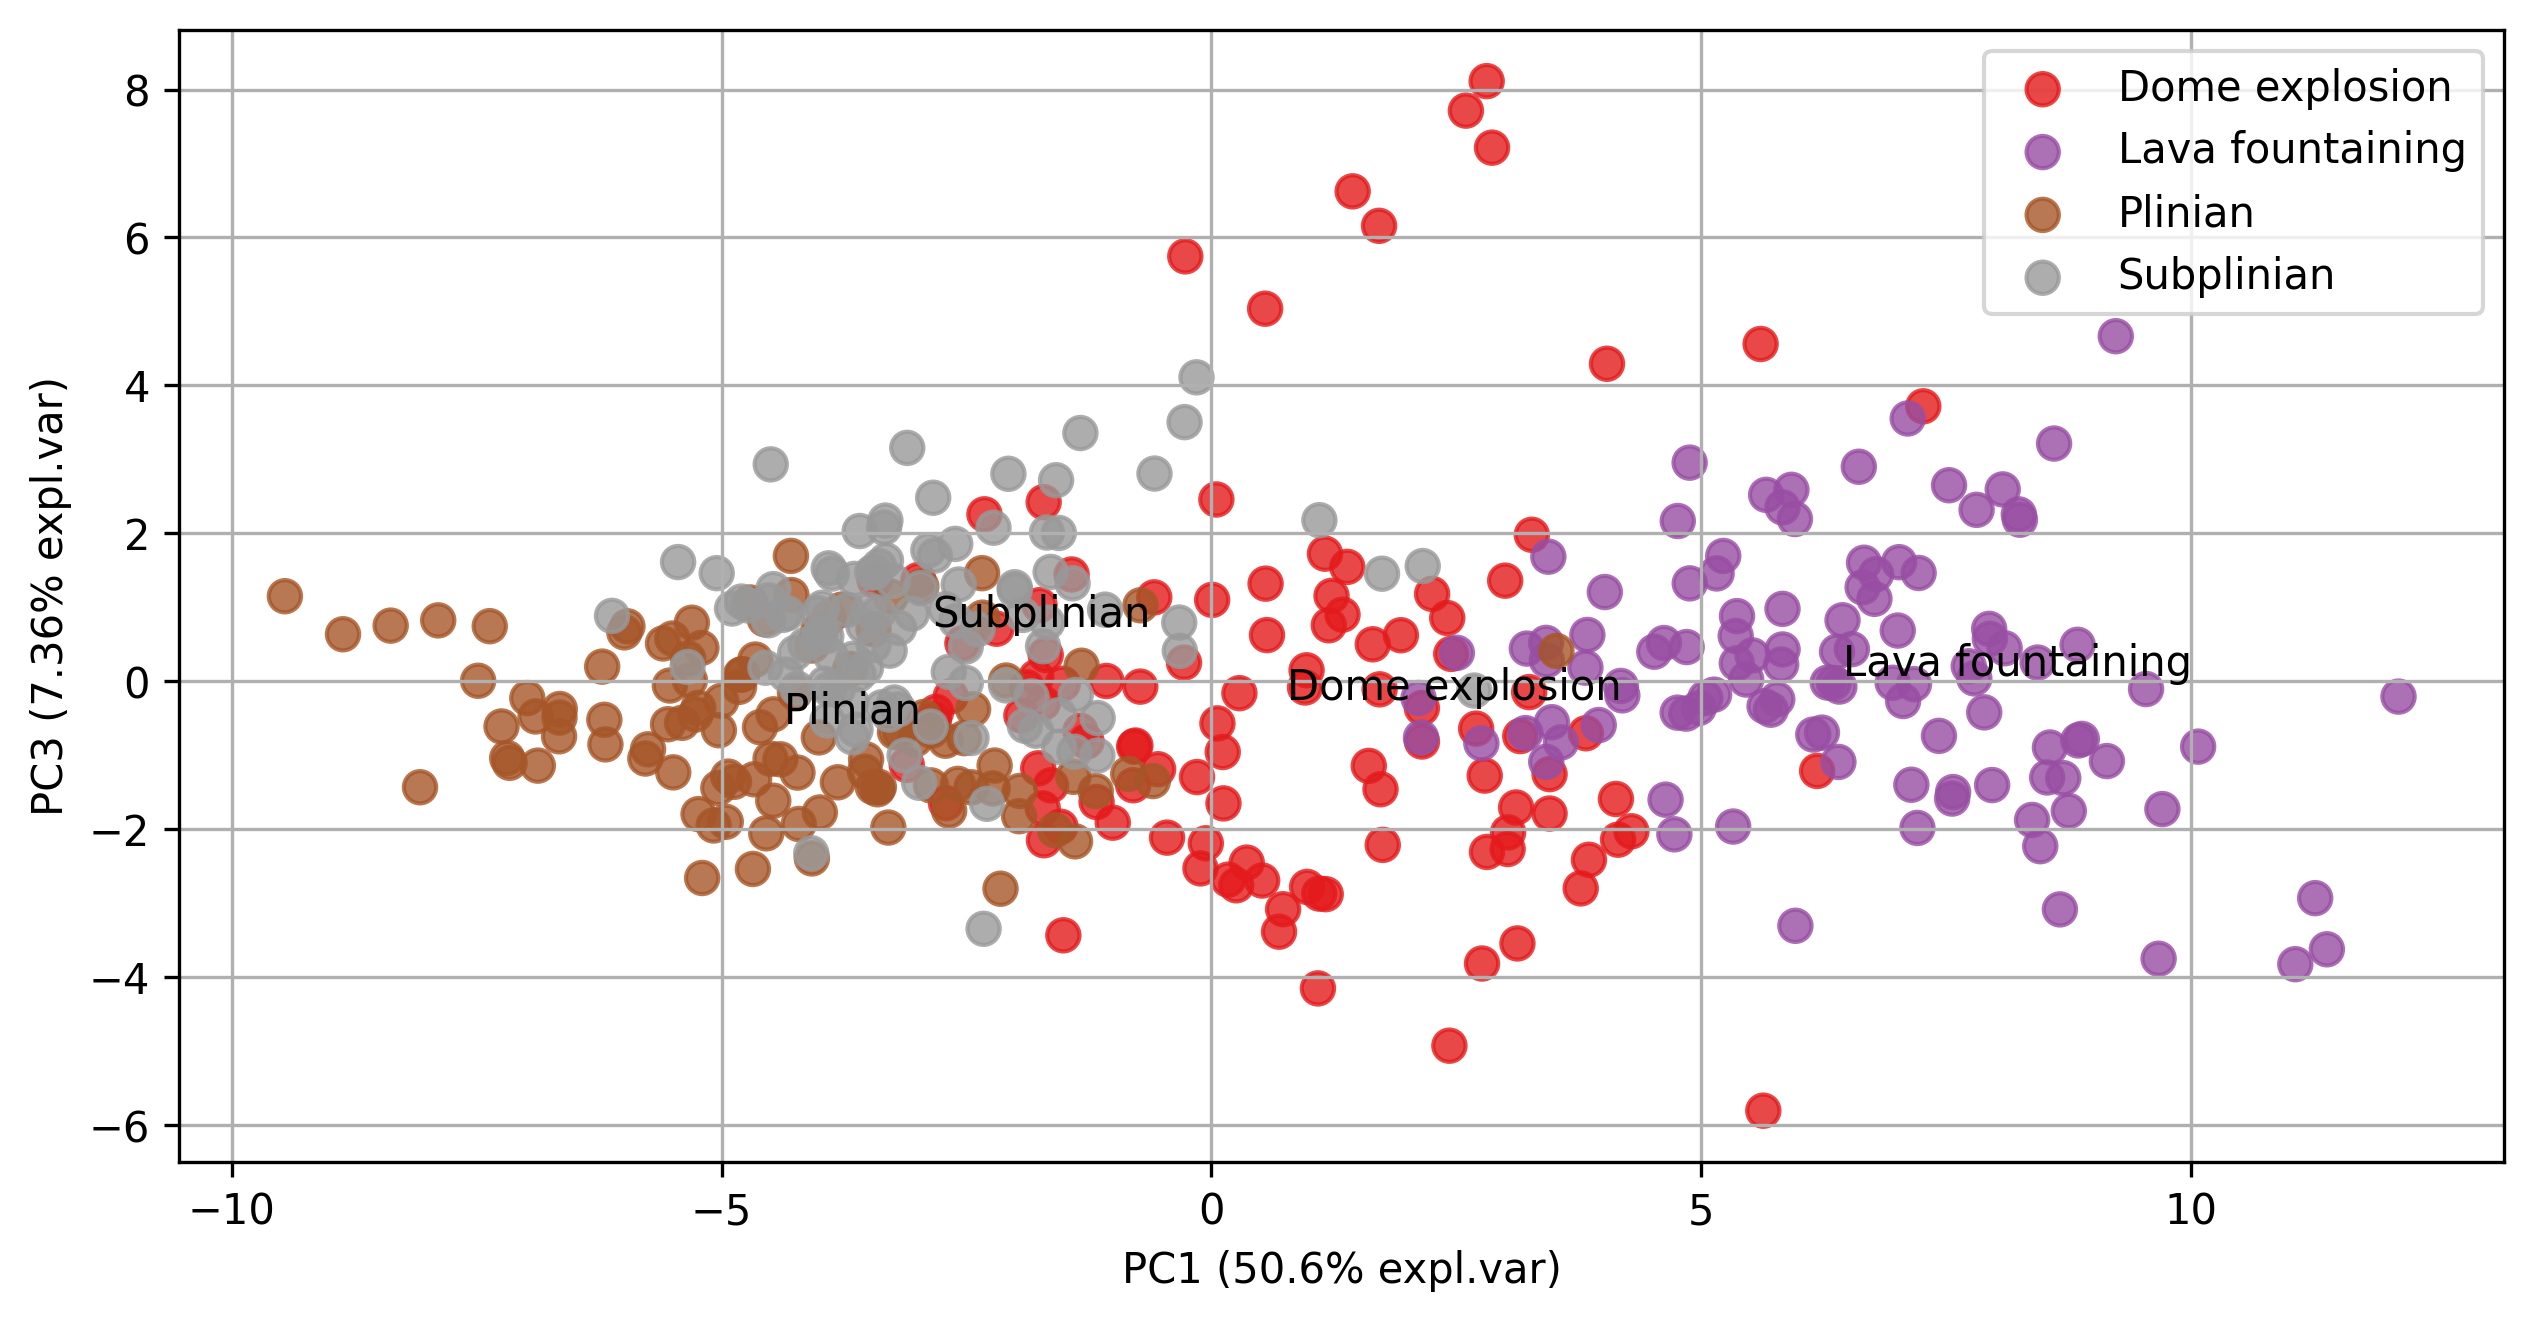

In [ ]:
fig, ax = model.scatter(PC = [0,2], title = '', alpha_transparency=0.8)
fig.set_size_inches(10, 5)
fig.savefig('./pca/scatter_pc0_pc2.svg')

[pca] >Plot PC1 vs PC2 with loadings.


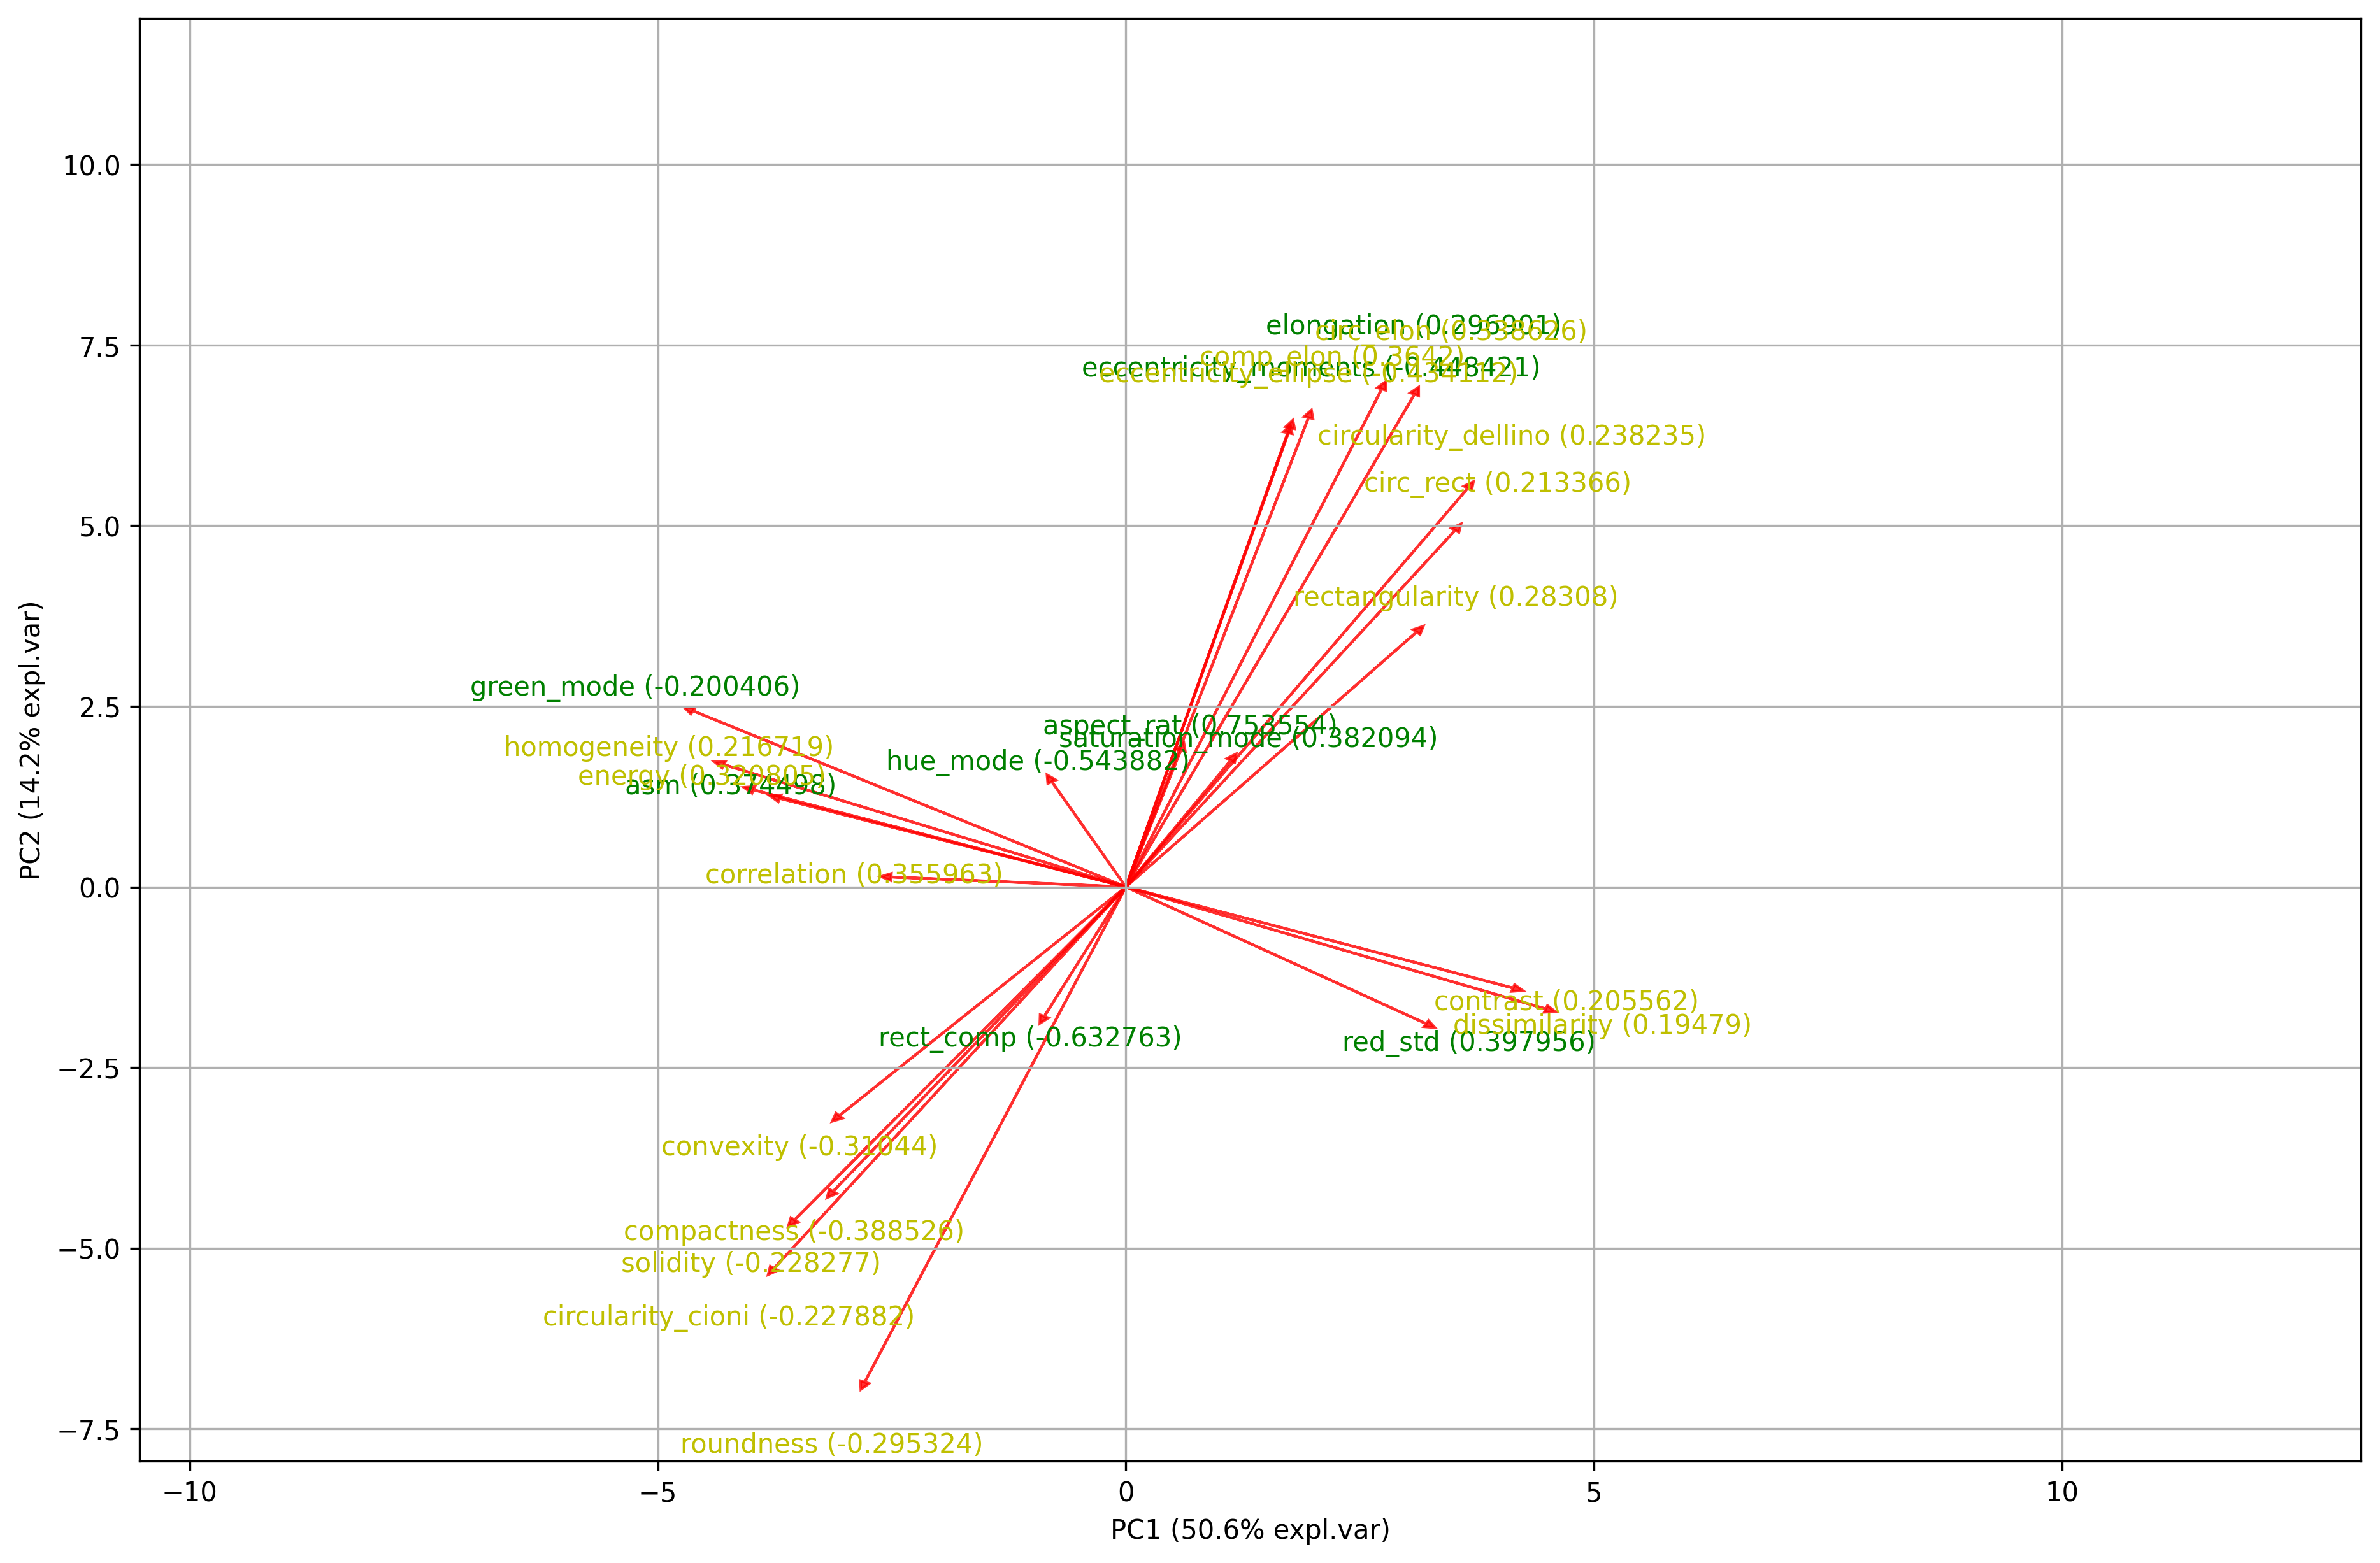

In [ ]:
# Make plot with parameters: set cmap to None and label and legend to False. Only directions will be plotted.
fig, ax =model.biplot(cmap=None, label=False, legend=False, title='')
fig.set_size_inches(8, 4)
fig.savefig('./pca/arrows.svg')

In [ ]:
#model.biplot3d()